In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
from netCDF4 import Dataset
from scipy.signal import windows
import xarray as xr
from matplotlib.lines import Line2D
from scipy import signal
from scipy.fft import fft, fftshift

In [2]:
# Load the .mat file
data=loadmat('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/forCristina_202409/data/interim_data/floridacurrent_198204.202012.mat')
fc_time=data['fcmonthly']['time'][0,0]
fc_trans=data['fcmonthly']['trans'][0,0]

In [3]:
# Flatten arrays if they have more than one dimension
if fc_time.ndim > 1:
    fc_time = np.ravel(fc_time)
if fc_trans.ndim > 1:
    fc_trans = np.ravel(fc_trans)

# Convert numeric time to datetime
# Assuming fc_time is in months since January 1982
start_date = pd.Timestamp('1982-01-01')

# Convert months to datetime
try:
    fc_dates = [start_date + pd.DateOffset(months=int(month)) for month in fc_time]
except ValueError as e:
    fc_dates = pd.date_range(start=start_date, periods=len(fc_time), freq='M')
    

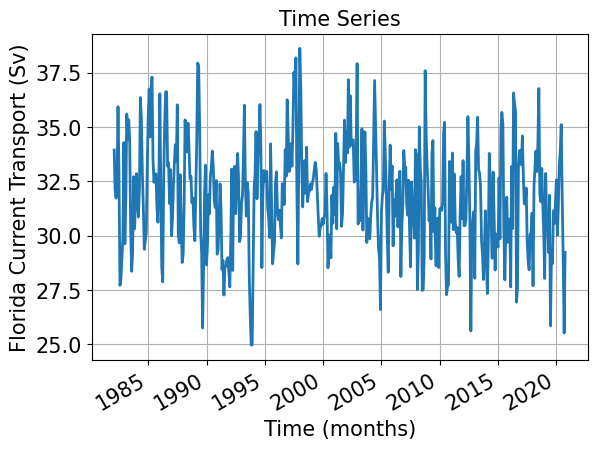

In [5]:
fc_series=pd.Series(fc_trans)# Need to convert to pandas to use rolling
#Filtering using Tukey: M=Tukey window size
alpha=0.66
#18-month Tukey filter window
fc_trans_tukey_18months=fc_series.rolling(window=18,center=True).apply(lambda x:np.sum(x*windows.tukey(18,alpha))
                                                                     /np.sum(windows.tukey(18,alpha)),raw=True)

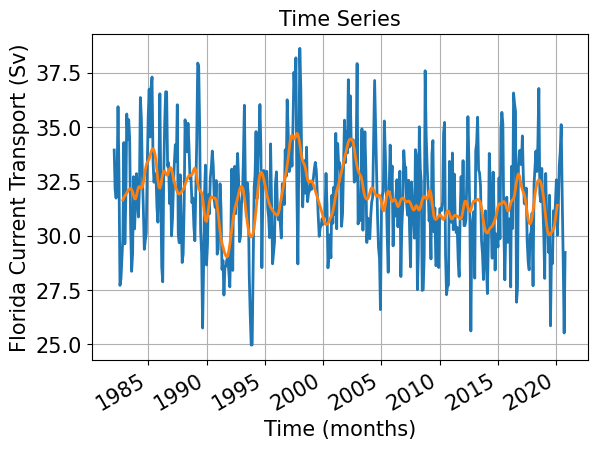

In [6]:
plt.figure()
plt.plot(fc_dates, fc_trans, color='C0', linewidth=2,label='Original data' )
plt.plot(fc_dates,fc_trans_tukey_18months,color='C1',linewidth=2,label='Tukey filter')
plt.grid(True)
plt.ylabel('Florida Current Transport (Sv)', fontsize=15)
plt.xlabel('Time (months)', fontsize=15)
plt.title('Time Series', fontsize=15)
plt.gca().tick_params(axis='both', which='major', labelsize=15)
plt.gcf().autofmt_xdate()
plt.show()

In [7]:
# Using Pandas
# Create a DataFrame for easier manipulation
df=pd.DataFrame({'Date':fc_dates,'Transport':fc_trans})
df.set_index('Date',inplace=True)# Set the date column as the index

# Seasonal cycle and std of the Florida Current
monthly_data=df.resample('M').mean()
seasonal_cycle=monthly_data.groupby(df.index.month).mean()
seasonal_std=monthly_data.groupby(df.index.month).std()


In [8]:
# Using Xarray (as Eleonor's group)
fc_dates_xarray=np.array(fc_dates,dtype='datetime64')#Converts fc_dates to an xarray datetime64 array
fc_data_xarray=xr.DataArray(fc_trans,coords=[fc_dates], dims=["time"])#create DataArray with dates and trans data

# Following steps similar to pandas: 
monthly_data_xarray=fc_data_xarray.resample(time="M").mean()#resample data to monthly frequency + compute each month mean
seasonal_cycle_xarray=monthly_data_xarray.groupby("time.month").mean(dim="time")#compute the mean of each month group
seasonal_std_xarray=monthly_data_xarray.groupby("time.month").std(dim="time")#compute seasonal cycle std

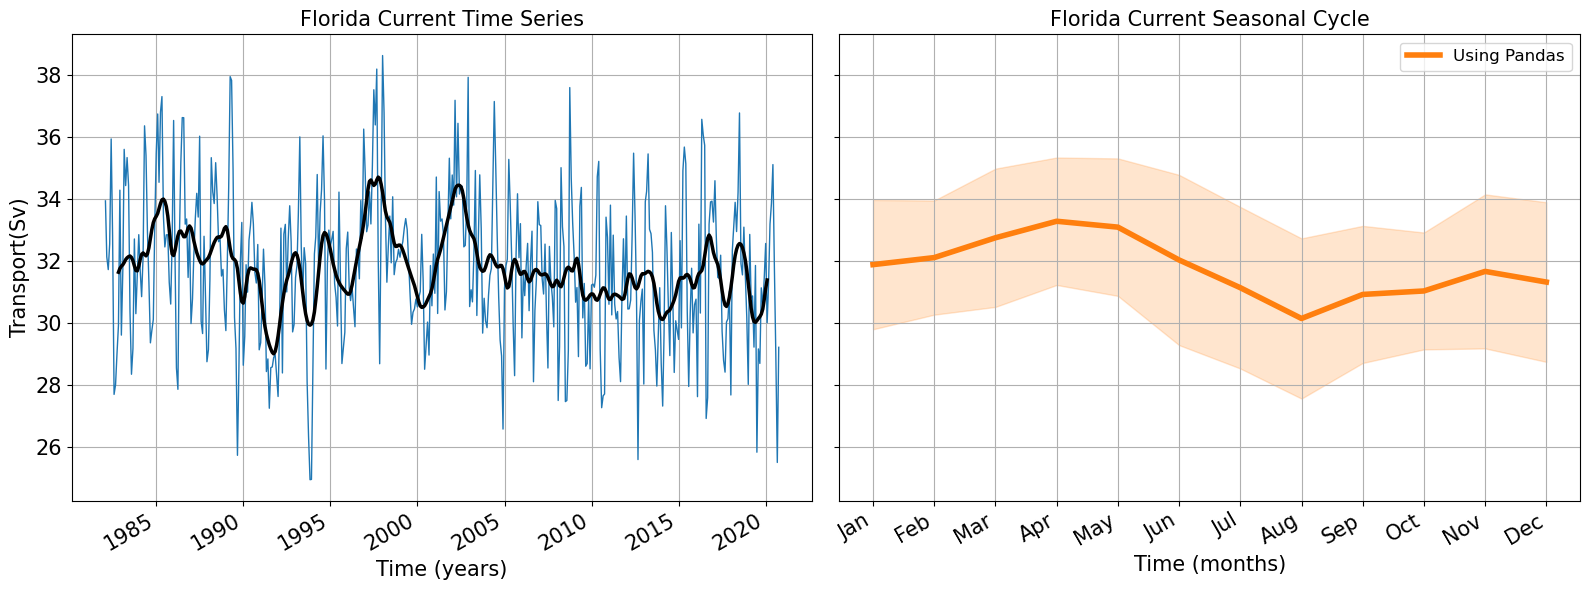

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
months = np.arange(1, 13)

# FIRST: Florida Current Time Series
ax[0].plot(df.index,df['Transport'],color='C0',linewidth=1)#C0 is blue
ax[0].plot(fc_dates,fc_trans_tukey_18months,color='k',linewidth=2.5)
ax[0].grid(True)
ax[0].set_ylabel('Transport(Sv)',fontsize=15)
ax[0].set_title('Florida Current Time Series',fontsize=15)
ax[0].set_xlabel('Time (years)',fontsize=15)
ax[0].tick_params(axis='both',which='major',labelsize=15)

# SECOND: Florida Current Seasonal Cycle
ax[1].plot(seasonal_cycle.index,seasonal_cycle['Transport'],color='C1',linewidth=4,label='Using Pandas')#C1 is orange
ax[1].fill_between(months,seasonal_cycle['Transport']-seasonal_std['Transport'], 
                   seasonal_cycle['Transport']+seasonal_std['Transport'],color='C1',alpha=0.2)
#ax[1].plot(np.arange(1,13),seasonal_cycle_xarray,color='k',linestyle='--',linewidth=1.5,label='Using Xarray')  # C0 is blue
#ax[1].fill_between(np.arange(1,13),seasonal_cycle_xarray-seasonal_std_xarray,
                   #seasonal_cycle_xarray+seasonal_std_xarray,color='k',alpha=0.1)
ax[1].grid(True)
ax[1].set_xlabel('Time (months)',fontsize=15)
ax[1].set_xticks(np.arange(1,13))
ax[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15)
ax[1].set_title('Florida Current Seasonal Cycle',fontsize=15)
ax[1].legend(loc='upper right',fontsize=12)

fig.autofmt_xdate() #Rotate time labels
plt.tight_layout()
plt.show()

In [10]:
# Load the NetCDF file
file_path='/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/MOC_rapid/moc_transports.nc'
nc_data=Dataset(file_path,'r')

# Extract variables
time=nc_data.variables['time'][:]
time_units=nc_data.variables['time'].units
moc=nc_data.variables['moc_mar_hc10'][:]
umo=nc_data.variables['t_umo10'][:]
florida_straits=nc_data.variables['t_gs10'][:]
ekman=nc_data.variables['t_ek10'][:]

# Convert time to pandas datetime
def convert_time_units(time,units):
    import calendar
    base_date=pd.to_datetime(units.split('since ')[1])
    return pd.to_datetime(base_date)+pd.to_timedelta(time,unit='days')

dates=convert_time_units(time,time_units)
#print(dates) I have 2 points every day
#print(time)
#print(dates)
#print(time_units)

#USING PANDAS
# Create DataFrames for easier manipulation
df_moc=pd.DataFrame({'Date':dates,'Transport':moc})
df_umo=pd.DataFrame({'Date':dates,'Transport':umo})
df_florida_straits=pd.DataFrame({'Date':dates,'Transport':florida_straits})
df_ekman=pd.DataFrame({'Date':dates,'Transport':ekman})

# Set the date column as the index
df_moc.set_index('Date',inplace=True)
df_umo.set_index('Date',inplace=True)
df_florida_straits.set_index('Date',inplace=True)
df_ekman.set_index('Date',inplace=True)

# Compute seasonal cycles and standard deviations
def compute_seasonal_cycle(df):
    df=df.dropna()
    monthly_data=df.resample('M').mean()
    seasonal_cycle=monthly_data.groupby(monthly_data.index.month).mean()
    seasonal_std=monthly_data.groupby(monthly_data.index.month).std()
    return seasonal_cycle,seasonal_std

seasonal_cycle_moc,seasonal_std_moc=compute_seasonal_cycle(df_moc)
seasonal_cycle_umo,seasonal_std_umo=compute_seasonal_cycle(df_umo)
seasonal_cycle_florida_straits,seasonal_std_florida_straits=compute_seasonal_cycle(df_florida_straits)
seasonal_cycle_ekman,seasonal_std_ekman=compute_seasonal_cycle(df_ekman)

In [11]:
# USING XARRAY
dates_xarray=np.array(dates,dtype='datetime64')#Converts fc_dates to an xarray datetime64 array

#create DataArray with dates and trans data
moc_xarray=xr.DataArray(moc,coords=[dates_xarray],dims=["time"])
umo_xarray=xr.DataArray(umo,coords=[dates_xarray],dims=["time"])
florida_straits_xarray=xr.DataArray(florida_straits,coords=[dates_xarray],dims=["time"])
ekman_xarray=xr.DataArray(ekman,coords=[dates_xarray],dims=["time"])

# Function to compute seasonal cycle and standard deviation with xarray
def compute_seasonal_cycle_xarray(dates_xarray):
    monthly_data_xarray2=dates_xarray.resample(time="M").mean()#resample data to monthly frequency + compute each month mean
    seasonal_cycle_xarray2=monthly_data_xarray2.groupby("time.month").mean(dim="time")#compute the mean of each month group
    seasonal_std_xarray2=monthly_data_xarray2.groupby("time.month").std(dim="time")#compute seasonal cycle std
    return seasonal_cycle_xarray2, seasonal_std_xarray2

# Compute for each dataset
seasonal_cycle_moc_xarray,seasonal_std_moc_xarray=compute_seasonal_cycle_xarray(moc_xarray)
seasonal_cycle_umo_xarray,seasonal_std_umo_xarray=compute_seasonal_cycle_xarray(umo_xarray)
seasonal_cycle_florida_straits_xarray,seasonal_std_florida_straits_xarray=compute_seasonal_cycle_xarray(florida_straits_xarray)
seasonal_cycle_ekman_xarray,seasonal_std_ekman_xarray=compute_seasonal_cycle_xarray(ekman_xarray)

In [12]:
#Filtering: Need to convert to pandas to use rolling
moc_series=pd.Series(moc)
umo_series=pd.Series(umo)
florida_straits_series=pd.Series(florida_straits)
ekman_series=pd.Series(ekman)

#Filtering using Tukey: tukey(M, alpha=0.5, sym=True) M=Tukey window size, true for use in filter design
alpha=0.66
#M is the number of points, since this data is not monthly, there are 2 points for each day
#The number of points during 3 months is: 90 days × 2 points/day= 180 points
#The number of points during 12 months is: 365 days × 2 points/day= 730 points

#FIRST: 18-month Tukey window, which corresponds to 548 points
moc_tukey_18months=moc_series.rolling(window=548,center=True).apply(lambda x:np.sum(x*windows.tukey(548,alpha))/np.sum(windows.tukey(548,alpha)),raw=True)
umo_tukey_18months=umo_series.rolling(window=548,center=True).apply(lambda x:np.sum(x*windows.tukey(548,alpha))/np.sum(windows.tukey(548,alpha)),raw=True)
florida_straits_tukey_18months=florida_straits_series.rolling(window=548,center=True).apply(lambda x:np.sum(x*windows.tukey(548,alpha))/np.sum(windows.tukey(548,alpha)),raw=True)
ekman_tukey_18months=ekman_series.rolling(window=548,center=True).apply(lambda x:np.sum(x*windows.tukey(548,alpha))/np.sum(windows.tukey(548,alpha)),raw=True)

# SAME FOR FILTERED DATA (Create DataFrames for easier manipulation)
df_moc_tukey_18months=pd.DataFrame({'Date':dates,'Filtered_Transport':moc_tukey_18months})
df_umo_tukey_18months=pd.DataFrame({'Date':dates,'Filtered_Transport':umo_tukey_18months})
df_florida_straits_tukey_18months=pd.DataFrame({'Date':dates,'Filtered_Transport':florida_straits_tukey_18months})
df_ekman_tukey_18months=pd.DataFrame({'Date':dates,'Filtered_Transport':ekman_tukey_18months})

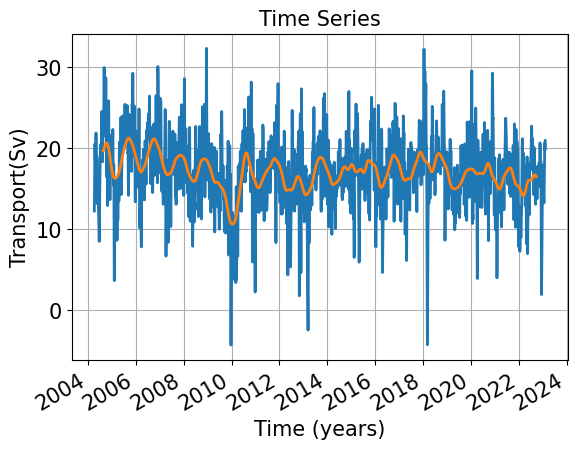

In [13]:
plt.figure()
plt.plot(dates,moc,color='C0',linewidth=2)
plt.plot(dates,moc_tukey_18months,color='C1',linewidth=2)
plt.grid(True)
plt.ylabel('Transport(Sv)',fontsize=15)
plt.title('Time Series',fontsize=15)
plt.xlabel('Time (years)',fontsize=15)
plt.gca().tick_params(axis='both',which='major',labelsize=15)
plt.gcf().autofmt_xdate()
plt.show()

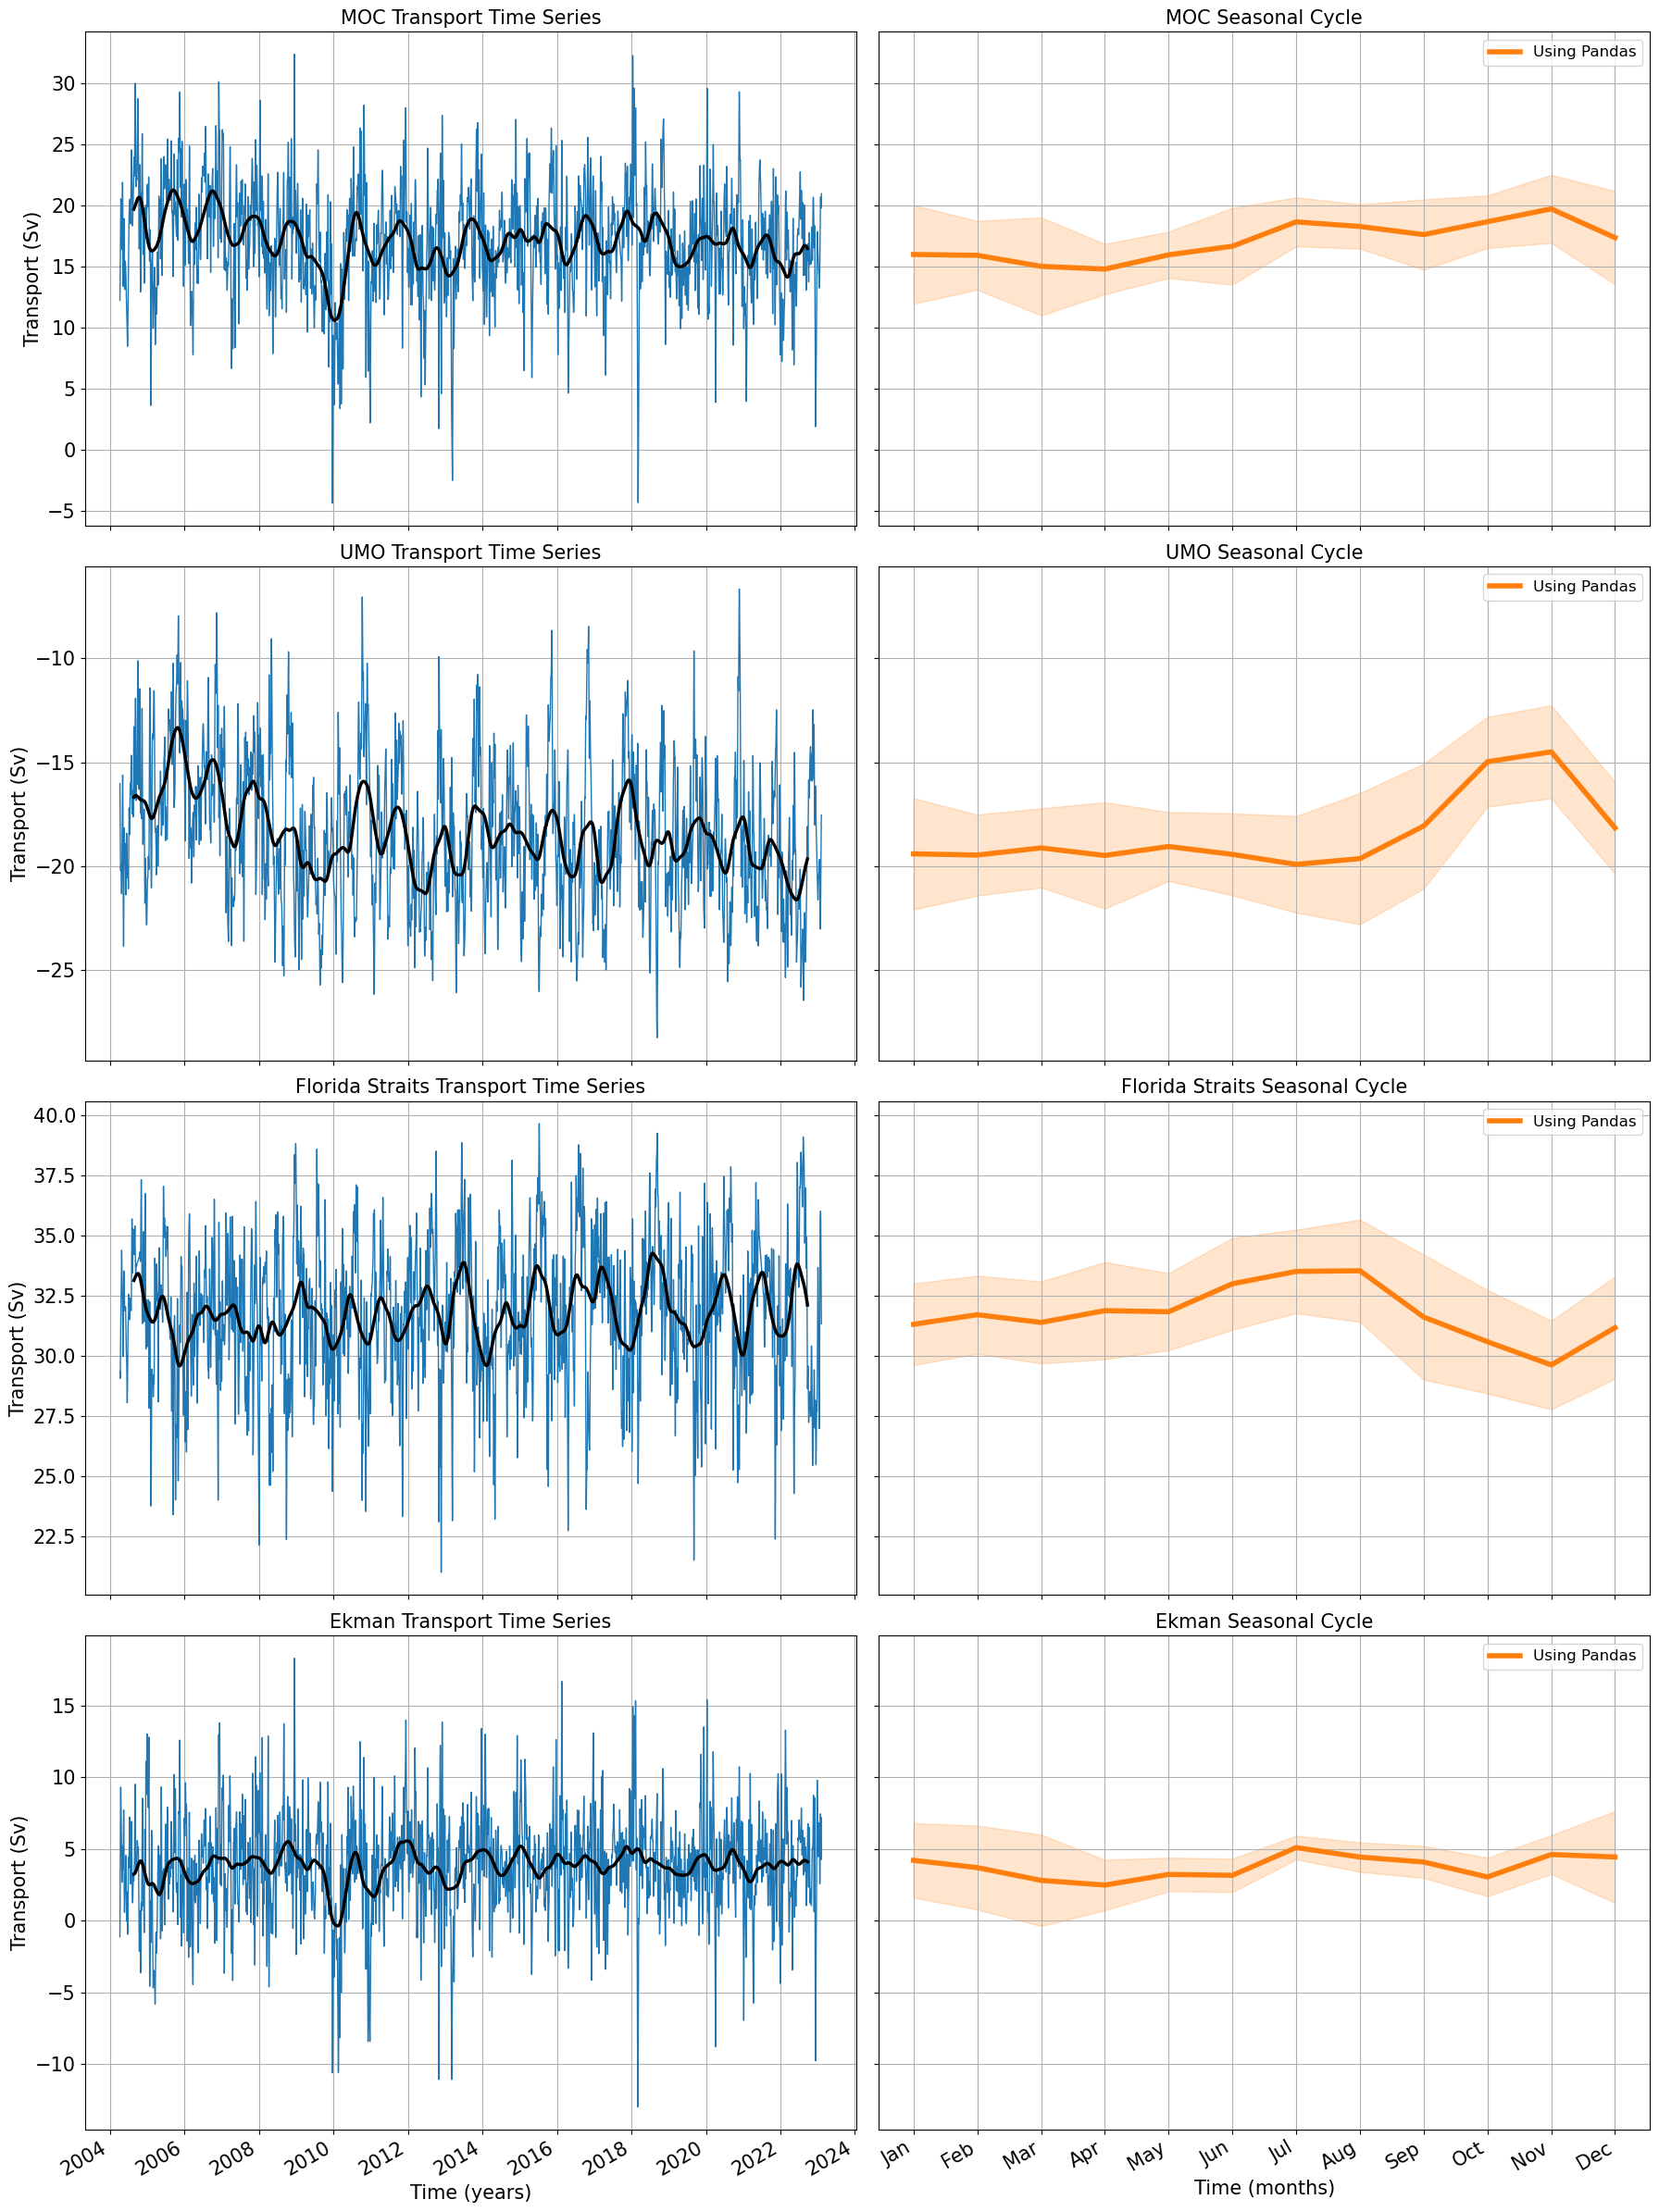

In [14]:
# Plotting
fig,ax=plt.subplots(4,2,figsize=(18,24),sharex='col',sharey='row')
months=np.arange(1,13)

def plot_time_series(ax, df, filtered_series, title):
    ax.plot(df.index,df['Transport'],color='C0',linewidth=1,label='Original Dataset')
    ax.plot(df.index,filtered_series['Filtered_Transport'],color='k',linewidth=2.5,label='Tukey Filtered')
    ax.grid(True)
    ax.set_ylabel('Transport (Sv)',fontsize=15)
    ax.set_title(title,fontsize=15)
    ax.tick_params(axis='both',which='major',labelsize=15)

def plot_seasonal_cycle(ax,seasonal_cycle,seasonal_cycle_xarray2,seasonal_std,title):
    ax.plot(months,seasonal_cycle['Transport'],color='C1',linewidth=4,label='Using Pandas')
    ax.fill_between(months,seasonal_cycle['Transport']-seasonal_std['Transport'], 
                    seasonal_cycle['Transport']+seasonal_std['Transport'],color='C1',alpha=0.2)
    #ax.plot(months,seasonal_cycle_xarray2,color='k',linestyle='--',linewidth=1.5,label='Using Xarray')
    ax.grid(True)
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15)
    ax.set_title(title,fontsize=15)
    ax.tick_params(axis='both',which='major',labelsize=15)
    ax.legend(loc='upper right',fontsize=12)


# Plot MOC
plot_time_series(ax[0,0],df_moc,df_moc_tukey_18months,'MOC Transport Time Series')
plot_seasonal_cycle(ax[0,1],seasonal_cycle_moc,seasonal_cycle_moc_xarray,seasonal_std_moc,'MOC Seasonal Cycle')

# Plot UMO
plot_time_series(ax[1,0],df_umo,df_umo_tukey_18months,'UMO Transport Time Series')
plot_seasonal_cycle(ax[1,1],seasonal_cycle_umo,seasonal_cycle_umo_xarray,seasonal_std_umo,'UMO Seasonal Cycle')

# Plot Florida Straits
plot_time_series(ax[2,0],df_florida_straits,df_florida_straits_tukey_18months,'Florida Straits Transport Time Series')
plot_seasonal_cycle(ax[2,1],seasonal_cycle_florida_straits,seasonal_cycle_florida_straits_xarray,seasonal_std_florida_straits,'Florida Straits Seasonal Cycle')

# Plot Ekman
plot_time_series(ax[3,0],df_ekman,df_ekman_tukey_18months,'Ekman Transport Time Series')
plot_seasonal_cycle(ax[3,1],seasonal_cycle_ekman,seasonal_cycle_ekman_xarray,seasonal_std_ekman,'Ekman Seasonal Cycle')

ax[3,1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15)
ax[3,0].tick_params(axis='both',which='major',labelsize=15)
ax[3,1].set_xlabel('Time (months)',fontsize=15)
ax[3,0].set_xlabel('Time (years)',fontsize=15)
    
fig.autofmt_xdate() #rotate xlabels
# Adjust layout
plt.tight_layout()
plt.show()

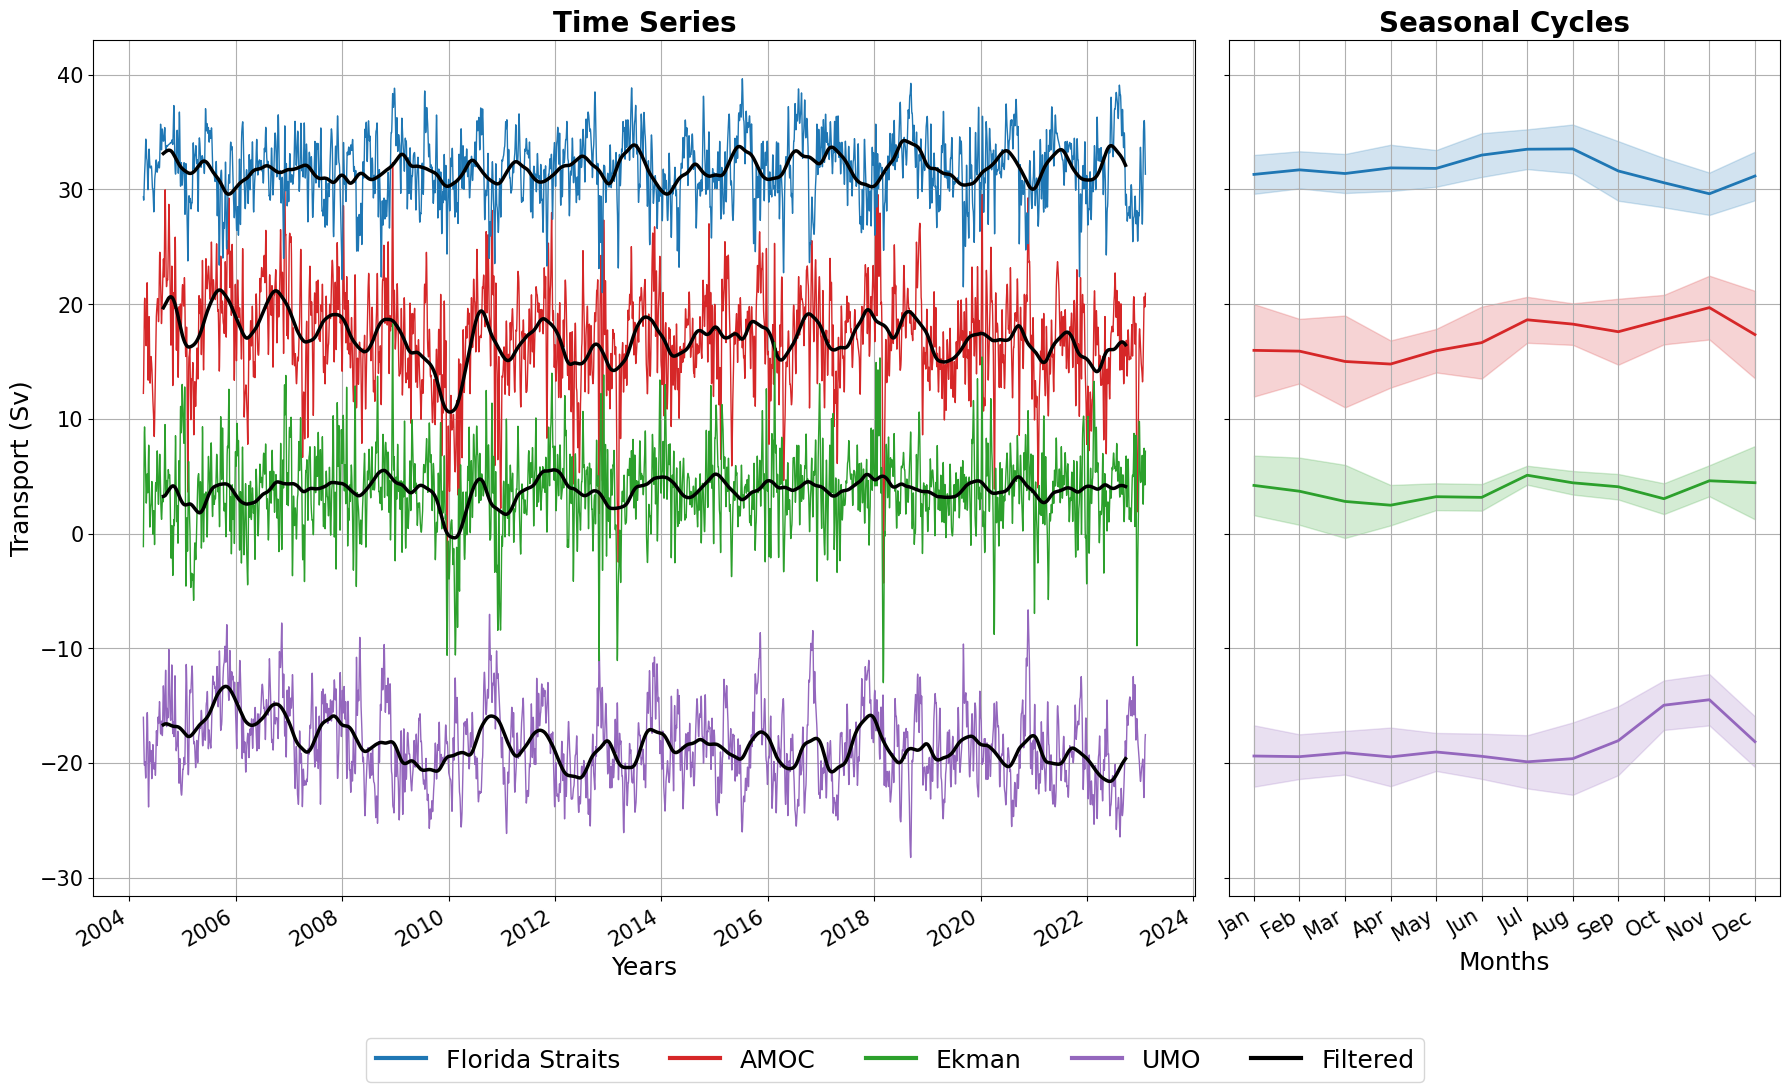

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10),sharey=True, gridspec_kw={'width_ratios': [2.5, 1]})
months = np.arange(1, 13)

# Plot all the time series in one subplot
ax[0].plot(df_moc.index, df_moc['Transport'], color='C3', linewidth=1, label='AMOC')
ax[0].plot(df_moc.index, df_moc_tukey_18months['Filtered_Transport'], color='k', linewidth=2.5, label='Filtered')
ax[0].plot(df_umo.index, df_umo['Transport'], color='C4', linewidth=1, label='UMO')
ax[0].plot(df_umo.index, df_umo_tukey_18months['Filtered_Transport'], color='k', linewidth=2.5)
ax[0].plot(df_florida_straits.index, df_florida_straits['Transport'], color='C0', linewidth=1, label='Florida Straits')
ax[0].plot(df_florida_straits.index, df_florida_straits_tukey_18months['Filtered_Transport'], color='k', linewidth=2.5)
ax[0].plot(df_ekman.index, df_ekman['Transport'], color='C2', linewidth=1, label='Ekman')
ax[0].plot(df_ekman.index, df_ekman_tukey_18months['Filtered_Transport'], color='k', linewidth=2.5)

ax[0].set_xlabel('Years',fontsize=18)
ax[0].set_ylabel('Transport (Sv)',fontsize=18)
ax[0].set_title('Time Series',fontsize=20,fontweight='bold')
ax[0].grid(True)
#ax[0].legend(loc='upper right',fontsize=12)
ax[0].tick_params(axis='both',which='major',labelsize=15)

# Plot all the seasonal cycles in the second subplot (right side)
ax[1].plot(months, seasonal_cycle_moc['Transport'],color='C3',linewidth=2,label='AMOC')
ax[1].fill_between(months, seasonal_cycle_moc['Transport'] - seasonal_std_moc['Transport'],
                   seasonal_cycle_moc['Transport'] + seasonal_std_moc['Transport'],color='C3',alpha=0.2)
ax[1].plot(months, seasonal_cycle_umo['Transport'], color='C4',linewidth=2, label='UMO')
ax[1].fill_between(months, seasonal_cycle_umo['Transport'] - seasonal_std_umo['Transport'],
                   seasonal_cycle_umo['Transport'] + seasonal_std_umo['Transport'],color='C4',alpha=0.2)
ax[1].plot(months, seasonal_cycle_florida_straits['Transport'], color='C0', linewidth=2, label='Florida Straits')
ax[1].fill_between(months, seasonal_cycle_florida_straits['Transport'] - seasonal_std_florida_straits['Transport'],
                   seasonal_cycle_florida_straits['Transport'] + seasonal_std_florida_straits['Transport'], color='C0', alpha=0.2)
ax[1].plot(months, seasonal_cycle_ekman['Transport'], color='C2', linewidth=2, label='Ekman')
ax[1].fill_between(months, seasonal_cycle_ekman['Transport'] - seasonal_std_ekman['Transport'],
                   seasonal_cycle_ekman['Transport'] + seasonal_std_ekman['Transport'], color='C2', alpha=0.2)

ax[1].set_xlabel('Months', fontsize=18)
#ax[1].set_ylabel('Transport (Sv)', fontsize=15)
ax[1].set_title('Seasonal Cycles', fontsize=20,fontweight='bold')
ax[1].set_xticks(np.arange(1, 13))
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=15)
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=15)
#ax[1].legend(loc='upper right',fontsize=12)

#legend at the bottom of the figure
legend_elements = [Line2D([0],[0],color='C0',lw=3,label='Florida Straits'),
                   Line2D([0],[0],color='C3',lw=3,label='AMOC'),
                   Line2D([0],[0],color='C2',lw=3,label='Ekman'),
                   Line2D([0],[0],color='C4',lw=3,label='UMO'),
                   Line2D([0],[0],color='k',lw=3,label='Filtered')]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=18, bbox_to_anchor=(0.5, -0.1))


fig.autofmt_xdate() #rotate xlabels
plt.tight_layout()
plt.show()



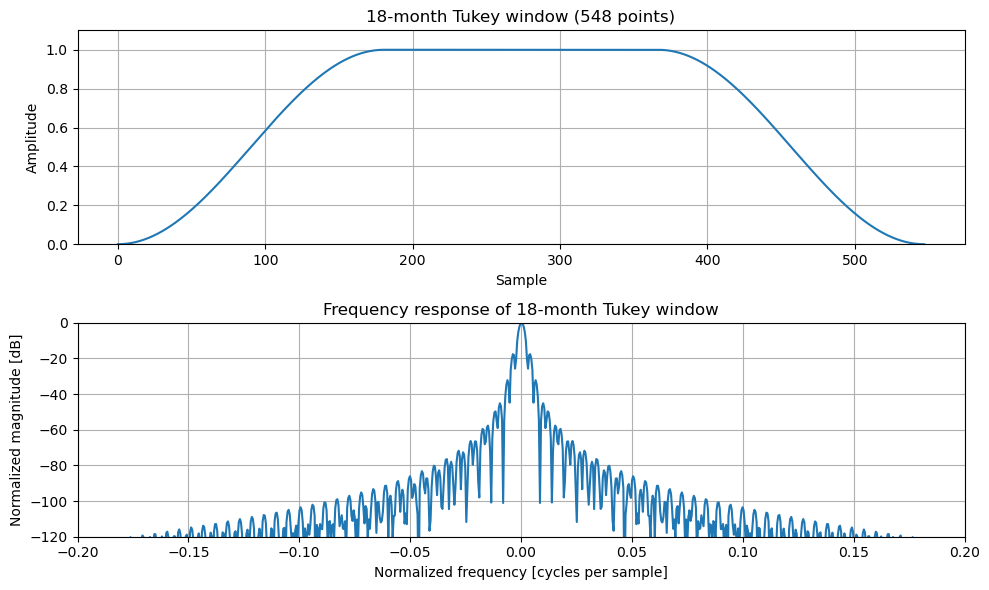

In [16]:
# Parameters
alpha = 0.66

# Create Tukey window for 18 months
window_18months = signal.windows.tukey(548, alpha)

# Compute frequency response
A_18 = fft(window_18months, 2048) / (len(window_18months) / 2.0)
freq_18 = np.linspace(-0.5, 0.5, len(A_18))
magnitude_18 = np.abs(fftshift(A_18 / abs(A_18).max()))

# Avoid log10 of zero by adding a small constant
magnitude_18 = np.where(magnitude_18 == 0, np.finfo(float).eps, magnitude_18)
response_18 = 20 * np.log10(magnitude_18)

# Plot for 18-month Tukey window
plt.figure(figsize=(10, 6))

# Plot the 18-month Tukey window
plt.subplot(2, 1, 1)
plt.plot(window_18months)
plt.title(f"18-month Tukey window (548 points)")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.ylim([0, 1.1])
plt.grid(True)

# Frequency response for the 18-month Tukey window
plt.subplot(2, 1, 2)
plt.plot(freq_18, response_18)
plt.axis([-0.2, 0.2, -120, 0])
plt.title("Frequency response of 18-month Tukey window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
# Convert indices to DatetimeIndex if they are not already
if not isinstance(df_umo.index, pd.DatetimeIndex):
    df_umo.index = pd.to_datetime(df_umo.index)
if not isinstance(df_moc.index, pd.DatetimeIndex):
    df_moc.index = pd.to_datetime(df_moc.index)
if not isinstance(df_umo_tukey_18months.index, pd.DatetimeIndex):
    df_umo_tukey_18months.index = pd.to_datetime(df_umo_tukey_18months.index)
if not isinstance(df_moc_tukey_18months.index, pd.DatetimeIndex):
    df_moc_tukey_18months.index = pd.to_datetime(df_moc_tukey_18months.index)

# Now create the DataArray objects
umo_data = xr.DataArray(df_umo['Transport'].values, 
                        coords=[df_umo.index], 
                        dims=['time'], 
                        name='UMO_Transport')
moc_data= xr.DataArray(df_moc['Transport'].values, 
                        coords=[df_moc.index], 
                        dims=['time'], 
                        name='MOC_Transport')
filtered_umo_data = xr.DataArray(df_umo_tukey_18months['Filtered_Transport'].values, 
                                 coords=[df_umo_tukey_18months.index], 
                                 dims=['time'], 
                                 name='Filtered_Transport_UMO')
filtered_moc_data = xr.DataArray(df_moc_tukey_18months['Filtered_Transport'].values, 
                                 coords=[df_moc_tukey_18months.index], 
                                 dims=['time'], 
                                 name='Filtered_Transport_MOC')

# Create a new xarray.Dataset
ds = xr.Dataset({
    'umo_data': umo_data,
    'filtered_umo_data': filtered_umo_data,
    'moc_data': moc_data,
    'filtered_moc_data': filtered_moc_data
})

# Save the dataset to a NetCDF file
#ds.to_netcdf('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/umo_amoc_data.nc')


In [18]:
# Check for NaN values in 'Transport' columns of the original datasets
nan_moc = df_moc['Transport'].isna().sum()
nan_umo = df_umo['Transport'].isna().sum()
nan_florida_straits = df_florida_straits['Transport'].isna().sum()
nan_ekman = df_ekman['Transport'].isna().sum()

# Print the results
print(f"NaN values in df_moc['Transport']: {nan_moc}")
print(f"NaN values in df_umo['Transport']: {nan_umo}")
print(f"NaN values in df_florida_straits['Transport']: {nan_florida_straits}")
print(f"NaN values in df_ekman['Transport']: {nan_ekman}")


NaN values in df_moc['Transport']: 20
NaN values in df_umo['Transport']: 20
NaN values in df_florida_straits['Transport']: 20
NaN values in df_ekman['Transport']: 20


In [19]:
# Check for NaN values of the original datasets

# df_moc
nan_moc_times = df_moc[df_moc['Transport'].isna()].index
nan_moc_count = df_moc['Transport'].isna().sum()

# df_umo
nan_umo_times = df_umo[df_umo['Transport'].isna()].index
nan_umo_count = df_umo['Transport'].isna().sum()

# df_florida_straits
nan_florida_straits_times = df_florida_straits[df_florida_straits['Transport'].isna()].index
nan_florida_straits_count = df_florida_straits['Transport'].isna().sum()

# df_ekman
nan_ekman_times = df_ekman[df_ekman['Transport'].isna()].index
nan_ekman_count = df_ekman['Transport'].isna().sum()

# Print the results
print(f"NaN values in df_moc['Transport']: {nan_moc_count}")
print(f"Timestamps with NaN values in df_moc: {nan_moc_times}")

print(f"NaN values in df_umo['Transport']: {nan_umo_count}")
print(f"Timestamps with NaN values in df_umo: {nan_umo_times}")

print(f"NaN values in df_florida_straits['Transport']: {nan_florida_straits_count}")
print(f"Timestamps with NaN values in df_florida_straits: {nan_florida_straits_times}")

print(f"NaN values in df_ekman['Transport']: {nan_ekman_count}")
print(f"Timestamps with NaN values in df_ekman: {nan_ekman_times}")


NaN values in df_moc['Transport']: 20
Timestamps with NaN values in df_moc: DatetimeIndex(['2004-04-02 00:00:00', '2004-04-02 12:00:00',
               '2004-04-03 00:00:00', '2004-04-03 12:00:00',
               '2004-04-04 00:00:00', '2004-04-04 12:00:00',
               '2004-04-05 00:00:00', '2004-04-05 12:00:00',
               '2004-04-06 00:00:00', '2004-04-06 12:00:00',
               '2023-02-06 12:00:00', '2023-02-07 00:00:00',
               '2023-02-07 12:00:00', '2023-02-08 00:00:00',
               '2023-02-08 12:00:00', '2023-02-09 00:00:00',
               '2023-02-09 12:00:00', '2023-02-10 00:00:00',
               '2023-02-10 12:00:00', '2023-02-11 00:00:00'],
              dtype='datetime64[ns]', name='Date', freq=None)
NaN values in df_umo['Transport']: 20
Timestamps with NaN values in df_umo: DatetimeIndex(['2004-04-02 00:00:00', '2004-04-02 12:00:00',
               '2004-04-03 00:00:00', '2004-04-03 12:00:00',
               '2004-04-04 00:00:00', '2004-04-04 12:

In [24]:
#Boxcar filter
# Apply the 3-month boxcar filter (90-point rolling mean)
moc_3months_boxcar = moc_series.rolling(window=90, center=True).mean()
umo_3months_boxcar = umo_series.rolling(window=90, center=True).mean()
florida_straits_3months_boxcar = florida_straits_series.rolling(window=90, center=True).mean()
ekman_3months_boxcar = ekman_series.rolling(window=90, center=True).mean()

# Apply the 1-year boxcar filter (365-point rolling mean) on the 3-month filtered data
moc_1year_boxcar = moc_3months_boxcar.rolling(window=365, center=True).mean()
umo_1year_boxcar = umo_3months_boxcar.rolling(window=365, center=True).mean()
florida_straits_1year_boxcar = florida_straits_3months_boxcar.rolling(window=365, center=True).mean()
ekman_1year_boxcar = ekman_3months_boxcar.rolling(window=365, center=True).mean()

# SAME FOR FILTERED DATA (Create DataFrames for easier manipulation)
df_moc_boxcar=pd.DataFrame({'Date':dates,'Filtered_Transport':moc_1year_boxcar})
df_umo_boxcar=pd.DataFrame({'Date':dates,'Filtered_Transport':umo_1year_boxcar})
df_florida_straits_boxcar=pd.DataFrame({'Date':dates,'Filtered_Transport':florida_straits_1year_boxcar})
df_ekman_boxcar=pd.DataFrame({'Date':dates,'Filtered_Transport':ekman_1year_boxcar})



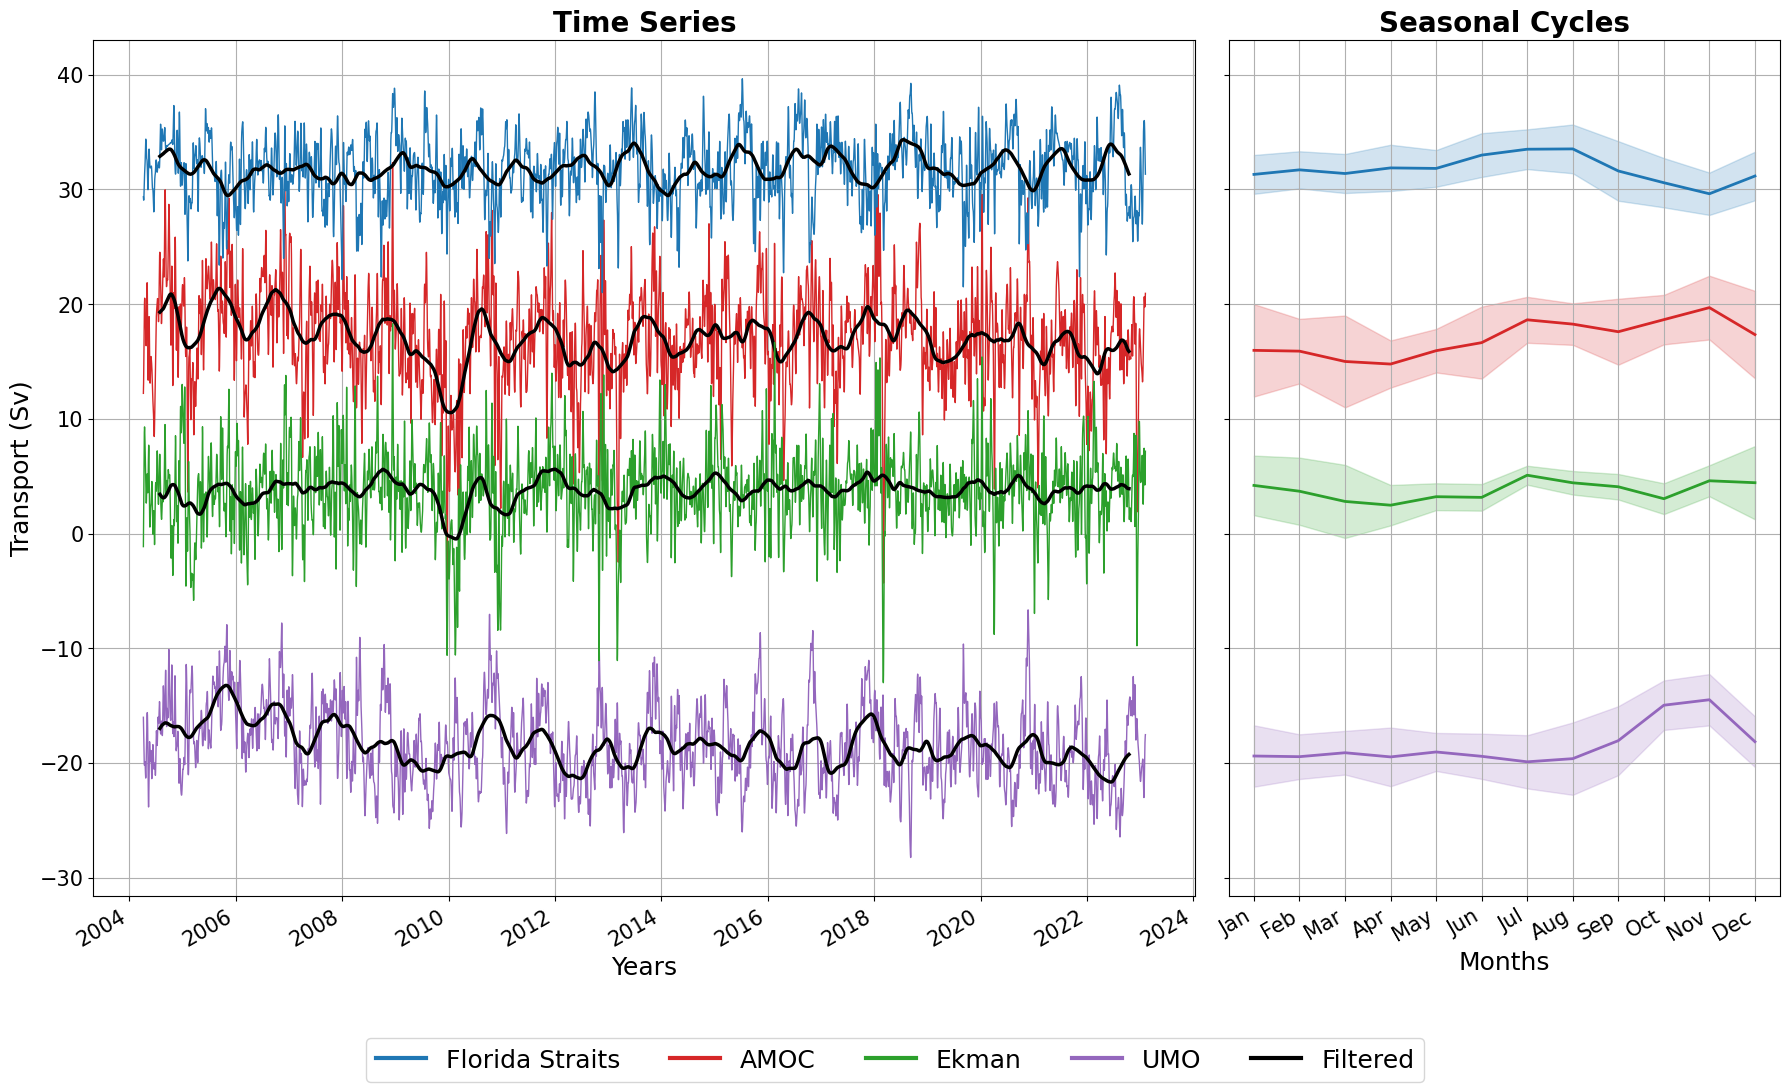

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10),sharey=True, gridspec_kw={'width_ratios': [2, 1]})
months = np.arange(1, 13)

# Plot all the time series in one subplot
ax[0].plot(df_moc.index, df_moc['Transport'], color='C3', linewidth=1, label='AMOC')
ax[0].plot(df_moc.index, df_moc_boxcar['Filtered_Transport'], color='k', linewidth=2.5, label='Filtered')
ax[0].plot(df_umo.index, df_umo['Transport'], color='C4', linewidth=1, label='UMO')
ax[0].plot(df_umo.index, df_umo_boxcar['Filtered_Transport'], color='k', linewidth=2.5)
ax[0].plot(df_florida_straits.index, df_florida_straits['Transport'], color='C0', linewidth=1, label='Florida Straits')
ax[0].plot(df_florida_straits.index, df_florida_straits_boxcar['Filtered_Transport'], color='k', linewidth=2.5)
ax[0].plot(df_ekman.index, df_ekman['Transport'], color='C2', linewidth=1, label='Ekman')
ax[0].plot(df_ekman.index, df_ekman_boxcar['Filtered_Transport'], color='k', linewidth=2.5)
ax[0].set_xlabel('Years',fontsize=18)
ax[0].set_ylabel('Transport (Sv)',fontsize=18)
ax[0].set_title('Time Series',fontsize=20,fontweight='bold')
ax[0].grid(True)
ax[0].tick_params(axis='both',which='major',labelsize=15)

# Plot all the seasonal cycles in the second subplot (right side)
ax[1].plot(months, seasonal_cycle_moc['Transport'],color='C3',linewidth=2,label='AMOC')
ax[1].fill_between(months, seasonal_cycle_moc['Transport'] - seasonal_std_moc['Transport'],
                   seasonal_cycle_moc['Transport'] + seasonal_std_moc['Transport'],color='C3',alpha=0.2)
ax[1].plot(months, seasonal_cycle_umo['Transport'], color='C4',linewidth=2, label='UMO')
ax[1].fill_between(months, seasonal_cycle_umo['Transport'] - seasonal_std_umo['Transport'],
                   seasonal_cycle_umo['Transport'] + seasonal_std_umo['Transport'],color='C4',alpha=0.2)
ax[1].plot(months, seasonal_cycle_florida_straits['Transport'], color='C0', linewidth=2, label='Florida Straits')
ax[1].fill_between(months, seasonal_cycle_florida_straits['Transport'] - seasonal_std_florida_straits['Transport'],
                   seasonal_cycle_florida_straits['Transport'] + seasonal_std_florida_straits['Transport'], color='C0', alpha=0.2)
ax[1].plot(months, seasonal_cycle_ekman['Transport'], color='C2', linewidth=2, label='Ekman')
ax[1].fill_between(months, seasonal_cycle_ekman['Transport'] - seasonal_std_ekman['Transport'],
                   seasonal_cycle_ekman['Transport'] + seasonal_std_ekman['Transport'], color='C2', alpha=0.2)

ax[1].set_xlabel('Months', fontsize=18)
ax[1].set_title('Seasonal Cycles', fontsize=20,fontweight='bold')
ax[1].set_xticks(np.arange(1, 13))
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=15)
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=15)

#To include the legend at the bottom of the figure
legend_elements = [Line2D([0],[0],color='C0',lw=3,label='Florida Straits'),
                   Line2D([0],[0],color='C3',lw=3,label='AMOC'),
                   Line2D([0],[0],color='C2',lw=3,label='Ekman'),
                   Line2D([0],[0],color='C4',lw=3,label='UMO'),
                   Line2D([0],[0],color='k',lw=3,label='Filtered')]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=18, bbox_to_anchor=(0.5, -0.1))


fig.autofmt_xdate() #rotate xlabels
plt.tight_layout()
plt.show()